In [7]:
import numpy as np
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split, KFold
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [8]:

class SoftmaxRegression:
    def __init__(self, learning_rate=0.1, num_iters=250, batch_size=1, sgd=False, alpha=0.001):
        '''
        Parameters
        ----------
        lr : learning rate of your optimizer.
        num_iters : number of iterations to run the optimizer.
        sgd : Indicates which optimizer is used, False -> GD, True -> SGD.
        alpha : Weight of the regularization (L2) term in the loss.
        '''
        self.learning_rate = learning_rate
        self.num_iters = num_iters
        self.sgd = sgd
        self.alpha = alpha
        self.batch_size = batch_size
        self.weights = None
        self.bias = None
        self.training_progress = None
        self.training_batch_progress = None
        self.test_progress = None

    def ce_loss(self, y_hat, y):
        '''
        Parameters
        ----------
        y_hat: array of predicted probabilities of size [num_samples, num_classes]
        y: array of true one-hot vectors of size [num_samples, num_classes]
        '''
        return -np.mean(y * np.log(y_hat))


    def softmax(self, logits):
        '''
        Parameters
        ----------
        logits: array of logits of size [num_samples, num_classes]

        Logits are unnormalized predictions (scores) from the model. These can not be interpreted as probabilities.
        Softmax converts these logits to probabilities.
        '''
        exps = np.exp(logits)
        return exps / np.sum(exps, axis=1, keepdims=True)

    def fit(self, X, y, tX=None, ty=None):
        '''
        Parameters
        ----------
        X: array of inputs of size [num_samples, num_features]
        y: array of targets of size [num_samples]

        Start by initializing appropriate weights.
        Calculate one-hot encodings of the targets.
        Compute the gradient at each training iteration using cross-entropy loss.
        Update weights and biases. Repeat for num_iters.

        NOTE: You need to implement both GD and SGD on the basis of self.sgd flag.
        '''
        num_samples, num_features = X.shape
        num_classes = len(np.unique(y))
        y_hot = np.zeros((len(y), num_classes))
        for i in range(len(y)):
            y_hot[i, y[i]] = 1
        if ty is not None:
            ty_hot = np.zeros((len(ty), num_classes))
            for i in range(len(ty)):
                ty_hot[i, ty[i]] = 1

        # initialize weights and bias
        self.weights = np.random.randn(num_features, num_classes)
        # self.weights = np.zeros((num_features, num_classes))
        self.bias = np.zeros((num_classes,))

        # For saving losses.
        self.training_progress = np.zeros(self.num_iters)
        self.training_batch_progress = np.zeros(self.num_iters)
        if tX is not None:
            self.test_progress = np.zeros(self.num_iters)

        for iter in range(self.num_iters):

            batchX = X
            batchy = y_hot

            # Training set loss.
            scores = np.dot(batchX, self.weights) + self.bias
            probs = self.softmax(scores)
            self.training_progress[iter] = self.ce_loss(probs, batchy)

            if self.sgd:
                batch_inds = np.random.choice(len(X), self.batch_size, replace=False)
                batchX = X[batch_inds, :]
                batchy = y_hot[batch_inds]

            scores = np.dot(batchX, self.weights) + self.bias
            probs = self.softmax(scores)

            # Batch loss (for sgd, batch = sample).
            self.training_batch_progress[iter] = self.ce_loss(probs, batchy)

            # calculate cross entropy loss and gradients
            if tX is not None:
              tscores = np.dot(tX, self.weights) + self.bias
              tprobs = self.softmax(tscores)
              self.test_progress[iter] = self.ce_loss(tprobs, ty_hot)

            d_scores = probs - batchy
            d_weights = np.dot(batchX.T, d_scores) / batchX.shape[0] + self.alpha * np.linalg.norm(self.weights)
            d_bias = np.sum(d_scores, axis=0) / d_scores.shape[0] + self.alpha * np.linalg.norm(self.bias)

            # update weights and bias
            self.weights -= self.learning_rate * d_weights
            self.bias -= self.learning_rate * d_bias

    def predict(self, X):
        '''
        Parameters
        ----------
        X: array of inputs of size [num_samples, num_features]

        Use trained model to compute predictions for given inputs.
        '''
        scores = np.dot(X, self.weights) + self.bias
        probs = self.softmax(scores)
        return np.argmax(probs, axis=1)

    def score(self, X, y):
        '''
        Parameters
        ----------
        X: array of inputs of size [num_samples, num_features]
        y: array of targets of size [num_samples]

        Use trained model to compute predictions for given inputs. Use the provided labels to compute accuracy.
        '''
        scores = np.dot(X, self.weights) + self.bias
        probs = self.softmax(scores)
        return np.count_nonzero(np.argmax(probs, axis=1) == y) / len(y)
    
    def fgsm_adversarial_example(self, X, y, epsilon=0.1):
        num_samples, _ = X.shape
        adv_X = np.copy(X)

        for i in range(num_samples):
            # Compute gradients of loss w.r.t. input
            x = X[i:i+1, :]  # select one sample at a time
            y_hot = np.zeros((1, self.weights.shape[1]))
            y_hot[0, y[i]] = 1  # one-hot encoding of true label
            scores = np.dot(x, self.weights) + self.bias
            probs = self.softmax(scores)
            loss = self.ce_loss(probs, y_hot)
            grad = np.dot(self.weights, (probs - y_hot).T).T  # gradient w.r.t input

            # Create adversarial example
            adv_x = x + epsilon * np.sign(grad)
            adv_x = np.clip(adv_x, 0, 1)  # Ensure the adversarial example remains within the valid input range
            adv_X[i] = adv_x

        return adv_X

In [9]:
digits = load_digits()
X_train, X_test, y_train, y_test = train_test_split(digits.data, digits.target, test_size=0.1)

In [10]:
clf = SoftmaxRegression(learning_rate=0.1)
clf.fit(X_train, y_train, X_test, y_test)
gd_progress = clf.training_progress
gd_tprogress = clf.test_progress

In [11]:
adv_examples = clf.fgsm_adversarial_example(X_test, y_test, epsilon=0.01)
original_predictions = clf.predict(X_test)
adv_predictions = clf.predict(adv_examples)
original_accuracy = clf.score(X_test, y_test)
adv_accuracy = clf.score(adv_examples, y_test)

print("Original Accuracy:", original_accuracy)
print("Adversarial Example Accuracy:", adv_accuracy)

Original Accuracy: 0.8666666666666667
Adversarial Example Accuracy: 0.49444444444444446


Text(0.5, 1.0, 'Predicted Label 8, Confidence 0.49444')

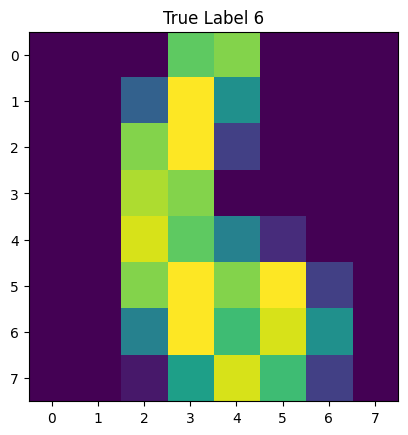

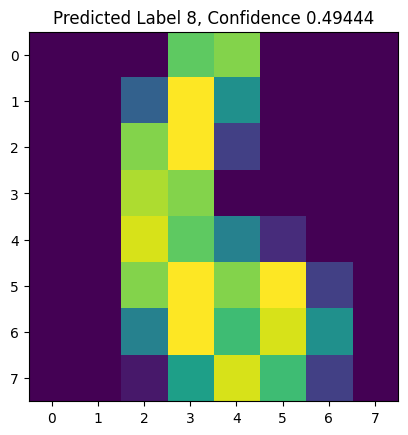

In [12]:
plt.imshow(digits.images[int(original_predictions[0])])
plt.title(f"True Label {original_predictions[0]}")

plt.figure()
plt.imshow(digits.images[int(original_predictions[0])])
plt.title(f"Predicted Label {adv_predictions[0]}, Confidence {adv_accuracy:.5f}")

### As we can see, the adversarial example is misclassified and the accuracy is much lower. 